In [1]:
import os
import numpy as np
os.chdir('utils')
from schroding_utils import *
from mlp_network import shared_model_func
from plotting import list_tensor_to_list, plot_loss, three_plots_schrod, heat_map_schrod

In [2]:
file_path = '../data/NLS.mat'

In [3]:
## Loading data
x, t, usol, usol_real, usol_img, usol_mag = load_data(file_path)

## Creating spatio-temporal grid
X, T = mesh_grid(x, t)

## Domain bounds
lb, ub = domain_bounds(-5.0, 5.0, 0.0, np.pi/2)

## Number of initial conditions training points
N0 = 50

## Number of boundary condition training points
N_b = 50

## Number of PDE structure (i.e. collocation) training points
N_f = 20000

## size of the neural network
## layers[0] == Input size
## layers[-1] == Output size
## layers[1:-1] == Number of units in between layers
layers = [2, 100, 100, 100, 100, 2]


## Preparing test data
X_test, y_u_test, y_v_test, y_h_test = test_data(X, T, usol_real, usol_img, usol_mag)

## Preparing training data
## choosing N0 random initial conditions
idx_x = np.random.choice(x.shape[0], N0, replace=False)
X_x_IC_train = x[idx_x,:] # spatial grid for train
X_u_IC_train = usol_real[idx_x,0:1] # real component for training
X_v_IC_train = usol_img[idx_x,0:1] # imaginary component for training

## chossing N_b boundary conditions
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
X_tb_train = t[idx_t,:]

## Generating a latin-hypercube design
X_f_train = lb + (ub-lb)*lhs(2, N_f)


# Concating training arrays
X_IC_train = np.concatenate((X_x_IC_train, 0*X_x_IC_train), 1) 
X_lb_train = np.concatenate((0*X_tb_train + lb[0], X_tb_train), 1)
X_ub_train = np.concatenate((0*X_tb_train + ub[0], X_tb_train), 1)

In [4]:
shared_model = shared_model_func(layers, lb=None, ub=None, norm=False)
# shared_model = shared_model_func(layers, lb=lb, ub=lb, norm=True)


shared_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          300         concatenate[0][0]            

In [5]:
# specifying the loss function
loss_function = tf.keras.losses.MeanSquaredError()

# Optimizer
optimizer = choose_optimizer(lr=0.0003, ds=1000, er=0.96, opt='Adam', lear_rate_sched=True)

## keeping them out of the @tf.function

In [6]:
# Data generation passing the entire batch
train_dataset = data_gen(X_f_train, batch_size=X_f_train.shape[0])
max_Iter = 15000
loss_u = []
loss_f = []
loss_model = []
loss_u_IC = [] 
loss_v_IC = []
loss_u_BC = []
loss_v_BC = []
loss_u_x_BC = []
loss_v_x_BC = []
loss_f_u = []
loss_f_v = []
tolerance = 0.03
loss_prev = 100000000
for epoch in tqdm(range(max_Iter)):
    for (X_f_train1, t_f_train1) in train_dataset:        
        loss_1, loss_2, loss_3, loss_4, loss_5, loss_6, loss_7, loss_8, loss_combine = model_build_compile(X_IC_train[:,0:1],
                                                                        X_IC_train[:,1:2], X_lb_train[:,0:1], 
                                                                        X_lb_train[:,1:2], X_ub_train[:,0:1], 
                                                                         X_ub_train[:,1:2], X_f_train[:,0:1], 
                                                                        X_f_train[:,1:2], shared_model, loss_function,
                                                                                    optimizer,X_u_IC_train, X_v_IC_train)
        loss_model.append(loss_combine)
        loss_u_IC.append(loss_1)
        loss_v_IC.append(loss_2)
        loss_u_BC.append(loss_3)
        loss_v_BC.append(loss_4)
        loss_u_x_BC.append(loss_5)
        loss_v_x_BC.append(loss_6)
        loss_f_u.append(loss_7)
        loss_f_v.append(loss_8)
        
    if ((epoch+1)%500 == 0):
        print("After {0} epochs combined loss is {1}".format(epoch+1, loss_combine.numpy()))
    # Early Stopping
    # My error was reducing for 10k and then it suddenly rises 
    # Expecting overfitting so I am putting a early stop condition here
#     if tolerance <= loss_combine.numpy() and loss_combine.numpy() < 2 * tolerance:
#         break
        

  0%|          | 0/15000 [00:00<?, ?it/s]

  3%|▎         | 502/15000 [01:21<40:41,  5.94it/s] 

After 500 epochs combined loss is 0.06792720451267087


  7%|▋         | 1002/15000 [02:39<39:22,  5.92it/s]

After 1000 epochs combined loss is 0.057246165992182796


 10%|█         | 1502/15000 [03:57<37:46,  5.95it/s]

After 1500 epochs combined loss is 0.05040852239540072


 13%|█▎        | 2002/15000 [05:15<36:22,  5.96it/s]

After 2000 epochs combined loss is 0.04308840634757871


 17%|█▋        | 2502/15000 [06:33<34:50,  5.98it/s]

After 2500 epochs combined loss is 0.03659152185105086


 20%|██        | 3002/15000 [07:51<33:33,  5.96it/s]

After 3000 epochs combined loss is 0.031233263136300593


 23%|██▎       | 3502/15000 [09:09<32:14,  5.94it/s]

After 3500 epochs combined loss is 0.027091961987594004


 27%|██▋       | 4002/15000 [10:27<30:41,  5.97it/s]

After 4000 epochs combined loss is 0.02435092848736531


 30%|███       | 4502/15000 [11:45<29:11,  5.99it/s]

After 4500 epochs combined loss is 0.021706776314999843


 33%|███▎      | 5002/15000 [13:03<27:48,  5.99it/s]

After 5000 epochs combined loss is 0.019330338486298615


 37%|███▋      | 5502/15000 [14:21<26:31,  5.97it/s]

After 5500 epochs combined loss is 0.017071449593458965


 40%|████      | 6002/15000 [15:39<25:07,  5.97it/s]

After 6000 epochs combined loss is 0.013997380836372031


 43%|████▎     | 6502/15000 [16:57<23:47,  5.95it/s]

After 6500 epochs combined loss is 0.013009652313030529


 47%|████▋     | 7002/15000 [18:15<22:30,  5.92it/s]

After 7000 epochs combined loss is 0.009804347611407138


 50%|█████     | 7502/15000 [19:33<20:58,  5.96it/s]

After 7500 epochs combined loss is 0.007878998954993222


 53%|█████▎    | 8002/15000 [20:51<19:33,  5.97it/s]

After 8000 epochs combined loss is 0.006459486626397393


 57%|█████▋    | 8502/15000 [22:09<18:11,  5.95it/s]

After 8500 epochs combined loss is 0.005474887498166936


 60%|██████    | 9002/15000 [23:27<16:41,  5.99it/s]

After 9000 epochs combined loss is 0.00464305211971805


 63%|██████▎   | 9502/15000 [24:45<15:23,  5.95it/s]

After 9500 epochs combined loss is 0.004008039477866987


 67%|██████▋   | 10002/15000 [26:03<14:00,  5.95it/s]

After 10000 epochs combined loss is 0.0035004445215349733


 70%|███████   | 10502/15000 [27:21<12:33,  5.97it/s]

After 10500 epochs combined loss is 0.004046448922053969


 73%|███████▎  | 11002/15000 [28:39<11:11,  5.95it/s]

After 11000 epochs combined loss is 0.0028741190325831667


 77%|███████▋  | 11502/15000 [29:57<09:45,  5.97it/s]

After 11500 epochs combined loss is 0.0023869767497899375


 80%|████████  | 12002/15000 [31:15<08:22,  5.97it/s]

After 12000 epochs combined loss is 0.002102960278136834


 83%|████████▎ | 12502/15000 [32:33<06:59,  5.96it/s]

After 12500 epochs combined loss is 0.001868303520268455


 87%|████████▋ | 13002/15000 [33:51<05:36,  5.94it/s]

After 13000 epochs combined loss is 0.0016618091272846414


 90%|█████████ | 13502/15000 [35:09<04:12,  5.94it/s]

After 13500 epochs combined loss is 0.0015104950301747522


 93%|█████████▎| 14002/15000 [36:27<02:47,  5.95it/s]

After 14000 epochs combined loss is 0.0013471145102812443


 97%|█████████▋| 14502/15000 [37:45<01:23,  5.93it/s]

After 14500 epochs combined loss is 0.0012102907016924291


100%|██████████| 15000/15000 [39:03<00:00,  6.40it/s]

After 15000 epochs combined loss is 0.001096573107020049


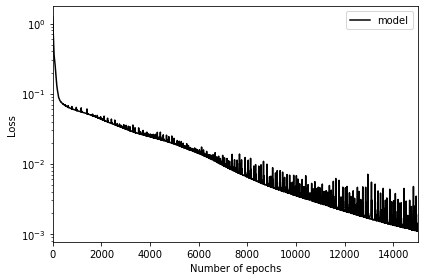

In [8]:
loss_num = list_tensor_to_list(loss_model)
xlab = r"Number of epochs"
ylab = r"Loss"
x111 = np.linspace(start = 0, stop = max_Iter, num = max_Iter, dtype = np.int)
plt.plot(x111, loss_num, 'k', label='model')
plt.yscale('log')
plt.xlabel(xlab, fontsize=10)
plt.ylabel(ylab, fontsize=10)
# plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=10)
plt.legend(loc='best', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.xlim([0, max_Iter])
plt.savefig('../figures/Schrodinger/schrod_loss_alone.png', dpi=500)
plt.show()

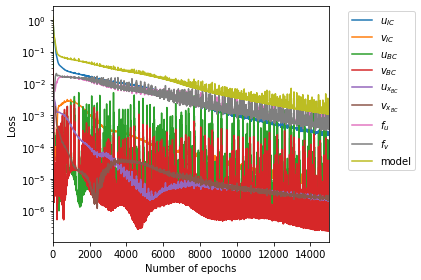

In [9]:
loss_list = [loss_u_IC, loss_v_IC, loss_u_BC, loss_v_BC, loss_u_x_BC, loss_v_x_BC, loss_f_u, loss_f_v, loss_model]
plot_loss(max_Iter, loss_list, 'schrod')

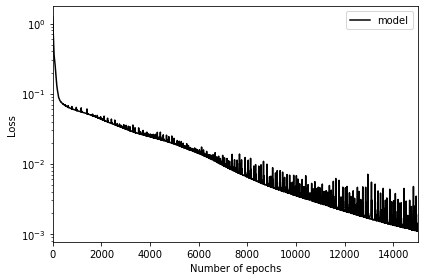

In [10]:
loss_num = list_tensor_to_list(loss_model)
xlab = r"Number of epochs"
ylab = r"Loss"
x111 = np.linspace(start = 0, stop = max_Iter, num = max_Iter, dtype = np.int)
plt.plot(x111, loss_num, 'k', label='model')
plt.yscale('log')
plt.xlabel(xlab, fontsize=10)
plt.ylabel(ylab, fontsize=10)
# plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=10)
plt.legend(loc='best', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.xlim([0, max_Iter])
plt.savefig('../figures/Schrodinger/schrod_loss_alone.png', dpi=500)
plt.show()

In [11]:
uv_hat = predict(shared_model, X_test)
u_hat, v_hat = uv_hat[:,0:1], uv_hat[:,1:2]
h_hat = np.sqrt(u_hat**2 + v_hat**2)

error_u = error_loss(y_u_test, u_hat)
error_v = error_loss(y_v_test, v_hat)
error_h = error_loss(y_h_test, h_hat)

print("*****************************************************\n")
print("Error for the real part of latent variable h is: {:e}".format(error_u))
print("Error for the imaginary part of latent variable h is: {:e}".format(error_v))
print("Error for the magnitude of variable h is: {:e}".format(error_h))
print("\n*****************************************************")

*****************************************************

Error for the real part of latent variable h is: 2.933348e-01
Error for the imaginary part of latent variable h is: 4.759021e-01
Error for the magnitude of variable h is: 6.675262e-02

*****************************************************


In [12]:
U_pred = griddata(X_test, u_hat.flatten(), (X, T), method='cubic')
V_pred = griddata(X_test, v_hat.flatten(), (X, T), method='cubic')
H_pred = griddata(X_test, h_hat.flatten(), (X, T), method='cubic')

<Figure size 432x288 with 0 Axes>

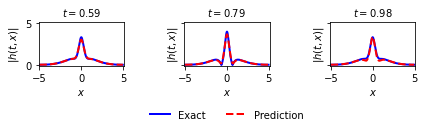

In [13]:
three_plots_schrod(x, t, usol_mag, H_pred)

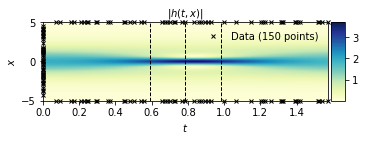

In [14]:
#Predicted solution on spatio-temporal grid
heat_map_schrod(H_pred, x,t, lb, ub, np.vstack([X_IC_train, X_lb_train, X_ub_train]), 'solution_heatmap')

In [15]:
# Error of the solution on spatio-temporal grid
H_true = griddata(X_test, y_h_test.flatten(), (X, T), method='cubic')

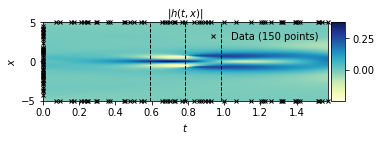

In [16]:
heat_map_schrod((H_true-H_pred), x,t, lb, ub, np.vstack([X_IC_train, X_lb_train, X_ub_train]), 'error_heatmap')

In [17]:
# Saves the model to Tensorflow SavedModel or a single HDF5 file.
shared_model.save(filepath='../models/Schrodinger/Schrodinger_shared_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../models/Schrodinger/Schrodinger_shared_model/assets


In [18]:
# save the weights
shared_model.save_weights('../models/Schrodinger/weights')